In [374]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [375]:
# GLOBAL VARS
dataset_size = None
batch_size = 32
log_iter = 2
global_emotion_label = 'emo8'

In [376]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [377]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [378]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [379]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [380]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [381]:
len(df)

25867

In [382]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [383]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [384]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [385]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [386]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [387]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [388]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
# torch.backends.cudnn.benchmark = True

True


In [389]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [390]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [391]:
face_model_base

Sequential(
  (0): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GEL

In [392]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [393]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [394]:
scene_model_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [395]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [396]:
get_category_name = lambda idx: scene_categories[idx]

In [397]:
scene_priors_path = os.path.join(data_dir, "scene_priors.xlsx")
scene_priors = pd.read_excel(scene_priors_path, index_col=0)
scene_priors.head()

,valence,arousal,nr_samples
scene_category,,,
airfield,4.000000,3.000000,2
airplane_cabin,3.059829,3.025641,117
airport_terminal,2.952381,2.190476,42
alcove,4.000000,1.000000,1
alley,3.130435,2.608696,23


In [398]:
def remove_brackets(lst):  
    return ', '.join(lst)

In [399]:
# Create the prolog file
prolog_file_name = "model8.pl"
prolog_file_path = os.path.join(prolog_dir, prolog_file_name)
with open(prolog_file_path, "w") as f:

    f.write("nn(face_model, [Face], Emotion,\n")
    f.write("   [angry, disgust, fear, happy, neutral, sad, surprise]) ::\n")
    f.write("   face_emotion(Face, Emotion).\n\n")

    f.write(f"nn(scene_model, [ScenePredictions], Scene, [{remove_brackets(list(scene_priors.index))}]) ::\n")
    f.write("   scene(ScenePredictions, Scene).\n\n")

    f.write(f"nn(va_to_emotion_model, [FaceFeat, SceneFeat, CV, CA], Emotion,\n")
    f.write(f"   [{remove_brackets(list(fe_labels))}]) ::\n")
    f.write("   va_to_emotion(FaceFeat, SceneFeat, CV, CA, Emotion).\n\n")

    for scene, row, in scene_priors.iterrows():
        if not (np.isnan(row['valence']) or np.isnan(row['arousal'])):
            f.write(f"scene_prior({scene}, {round(row['valence'], 2)}, {round(row['arousal'], 2)}).\n")
        else:
            # allocate random values for valence and arousal between 0 and 6
            valence = round(random.uniform(0, 6), 2)
            arousal = round(random.uniform(0, 6), 2)
            f.write(f"scene_prior({scene}, {valence}, {arousal}).\n")

    # Next step model these with gaussian distribution so we don't always have fixed values, maybe also for the scene priors
    f.write("\n")
    f.write("face_prior(angry, 1.2, 5.1).\n")
    f.write("face_prior(disgust, 0.9, 3.1).\n")
    f.write("face_prior(fear, 0.6, 5.4).\n")
    f.write("face_prior(happy, 5.4, 4.8).\n")
    f.write("face_prior(neutral, 3.0, 2.4).\n")
    f.write("face_prior(sad, 0.9, 1.5).\n")
    f.write("face_prior(surprise, 3.3, 5.4).\n")
    f.write("\n")

    f.write("small_diff(F, S)  :- abs(F - S) =< 1.\n")
    f.write("medium_diff(F, S) :- D is abs(F - S), D > 1, D =< 3.\n")
    f.write("large_diff(F, S)  :- abs(F - S) > 3.\n")

    f.write("\n")
    f.write(f"t(_) :: use_face_small_val(F,S) ; t(_) :: use_scene_small_val(F,S).\n")
    f.write(f"t(_) :: use_face_small_aro(F,S) ; t(_) :: use_scene_small_aro(F,S).\n")
    f.write(f"t(_) :: use_face_big_val(F,S) ; t(_) :: use_scene_big_val(F,S).\n")
    f.write(f"t(_) :: use_face_big_aro(F,S) ; t(_) :: use_scene_big_aro(F,S).\n")
    f.write("\n")

    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_face_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_scene_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_face_big_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_scene_big_val(FV, SV). \n")
    f.write("\n")

    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_face_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_scene_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_face_big_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_scene_big_aro(FA, SA). \n")
    f.write("\n")
    
    f.write("final_emotion(FacePredictions, ScenePredictions, FaceFeat, SceneFeat, Emotion) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA),\n")
    f.write("    combine_val(FV, SV, CV),\n")
    f.write("    combine_aro(FA, SA, CA),\n")
    f.write("    va_to_emotion(FaceFeat, SceneFeat, CV, CA, Emotion). \n")
    f.write("\n")

    f.write("test_va(FacePredictions, ScenePredictions, FV, FA, SV, SA) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA).\n")
    f.write("\n")
    
    f.write("test_combo(FacePredictions, ScenePredictions, CV, CA) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA),\n")
    f.write("    combine_val(FV, SV, CV),\n")
    f.write("    combine_aro(FA, SA, CA).\n")
    f.write("\n")

print("Prolog file written to:", prolog_file_path)

Prolog file written to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog\model8.pl


In [400]:
class FacePredictionsDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(7, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_predictions = FacePredictionsDataset(indices, os.path.join(data_dir, "pretrained_logits"))

In [401]:
# Maybe precalculate these again with blurred faces in scenes folder of pretrained_logits
class ScenePredictionsDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu") 

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_predictions = ScenePredictionsDataset(indices, os.path.join(data_dir, "pretrained_logits"))

In [402]:
class FaceNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable temperature so outputs require grad
        self.temp = nn.Parameter(torch.tensor(1.0))

    def forward(self, tensor):
        """
        Load all face logits for an image, average logits across faces, then softmax once.
        """
        device = self.temp.device
        tensor = tensor.to(device)
        probs = torch.softmax(tensor * self.temp, dim=-1)           # (num_classes,)
        return probs

In [403]:
face_model_torch = FaceNet()
face_network = Network(face_model_torch, "face_model", batching=True)
face_network.optimizer = optim.Adam(face_model_torch.parameters(), lr=0.001)

In [404]:
class SceneNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable temperature so outputs require grad
        self.temp = nn.Parameter(torch.tensor(1.0))
    def forward(self, tensor):
        """
        Load all face logits for an image, average logits across faces, then softmax once.
        """
        device = self.temp.device
        tensor = tensor.to(device)
        probs = torch.softmax(tensor * self.temp, dim=-1)           # (num_classes,)
        return probs

In [405]:
scene_model_torch = SceneNet()
scene_network = Network(scene_model_torch, "scene_model", batching=True)
scene_network.optimizer = optim.Adam(scene_model_torch.parameters(), lr=0.001)

In [406]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [407]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    result =  {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
    print_dpl_detailed_metrics(result, fe_labels)

    model.train()
    return result


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [408]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face backbone features (768 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(768, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (768,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features = FaceFeatureDataset(indices, os.path.join(data_dir, "pretrained_backbone"))

In [409]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (512,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features = SceneFeatureDataset(indices, os.path.join(data_dir, "pretrained_backbone"))

In [410]:
class HybridEmotionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # ---- FEATURE PROJECTION ----
        self.face_proj = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.LayerNorm(256)
        )

        self.scene_proj = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256)
        )

        # Final input dim = 256(face) + 256(scene) + 2(VA)
        self.classifier = nn.Sequential(
            nn.Linear(514, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 8),   # 8 emotion classes
            nn.Softmax(dim=1)
        )

    def forward(self, face_feat, scene_feat, cv, ca):
        """
        face_feat:  (batch, 768) or (768,)
        scene_feat: (batch, 512) or (512,)
        cv, ca:     (batch, 1) or scalar
        """
        device = next(self.parameters()).device

        face_feat = torch.as_tensor(face_feat, device=device, dtype=torch.float32)
        scene_feat = torch.as_tensor(scene_feat, device=device, dtype=torch.float32)
        cv = torch.as_tensor(cv, device=device, dtype=torch.float32)
        ca = torch.as_tensor(ca, device=device, dtype=torch.float32)

        if face_feat.dim() == 1:
            face_feat = face_feat.unsqueeze(0)
        if scene_feat.dim() == 1:
            scene_feat = scene_feat.unsqueeze(0)
        if cv.dim() == 0:
            cv = cv.unsqueeze(0)
        if ca.dim() == 0:
            ca = ca.unsqueeze(0)

        # Ensure 2D shapes
        face_feat = face_feat.view(face_feat.size(0), -1)
        scene_feat = scene_feat.view(scene_feat.size(0), -1)
        cv = cv.view(cv.shape[0], 1)
        ca = ca.view(ca.shape[0], 1)

        face_z = self.face_proj(face_feat)
        scene_z = self.scene_proj(scene_feat)
        va = torch.cat([cv, ca], dim=1)  # (batch, 2)
        x = torch.cat([face_z, scene_z, va], dim=1)
        logits = self.classifier(x)
        return logits

hybrid_emotion_model = HybridEmotionModel()
hybrid_emotion_model.to(DEVICE)
hybrid_emotion_network = Network(hybrid_emotion_model, "va_to_emotion_model", batching=True)
hybrid_emotion_network.optimizer = optim.Adam(hybrid_emotion_model.parameters(), lr=0.001)

In [411]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        model_output = torch.load(os.path.join(data_dir, "pretrained_logits", "faces", f"face_{sample_idx}_{face_rank}.pt")).to(DEVICE).unsqueeze(0)
        probs_output = torch.softmax(model_output, dim=1)
        probs = probs_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_logits = torch.load(os.path.join(data_dir, "pretrained_logits", "scenes", f"scene_{sample_idx}.pt")).to(DEVICE)
    scene_probs = torch.softmax(scene_logits, dim=0)
   

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(scene_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_category_name(idx)}: {prob:.4f}")
    print("")


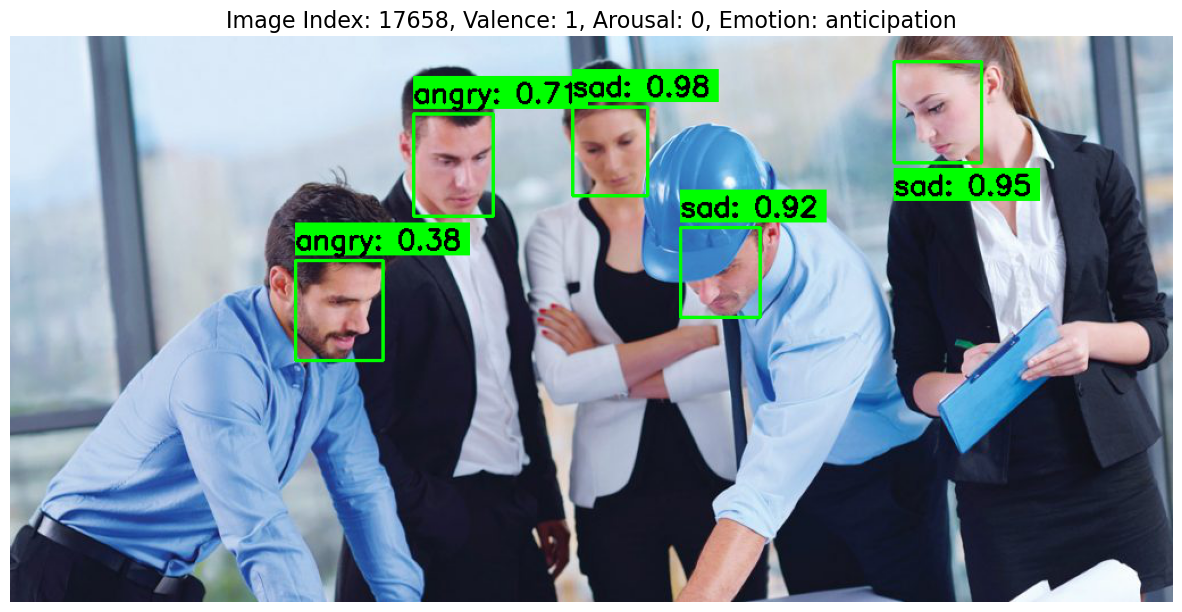

Base model (365 categories):
  hospital_room: 0.2227
  nursing_home: 0.1719
  office: 0.0816



In [412]:
random_sample_idx = random.randint(0, len(df) - 1)
show_pretrained_model_predictions_on_sample(random_sample_idx)

In [413]:
df[df.index == random_sample_idx]

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,nr_faces
17658,Run_2/Discontent elderly classroom/safety_cult...,Undefined,Adults,1,0,anticipation,Context,0,5


In [414]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    result =  {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
    print_dpl_detailed_metrics(result, fe_labels)

    model.train()
    return result


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [415]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model8.pl"), [scene_network, face_network, hybrid_emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 30, heuristic2))
model.add_tensor_source("face_predictions", face_predictions)
model.add_tensor_source("scene_predictions", scene_predictions)
model.add_tensor_source("face_features", face_features)
model.add_tensor_source("scene_features", scene_features)

model.optimizer = SGD(model, 5e-2)

In [416]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_predictions", Constant(idx))),
                Term("tensor", Term(f"scene_predictions", Constant(idx))),
                Term("tensor", Term(f"face_features", Constant(idx))),
                Term("tensor", Term(f"scene_features", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices)
test_dataset = FEQUeryDataset(test_indices[:1000])

In [417]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [418]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

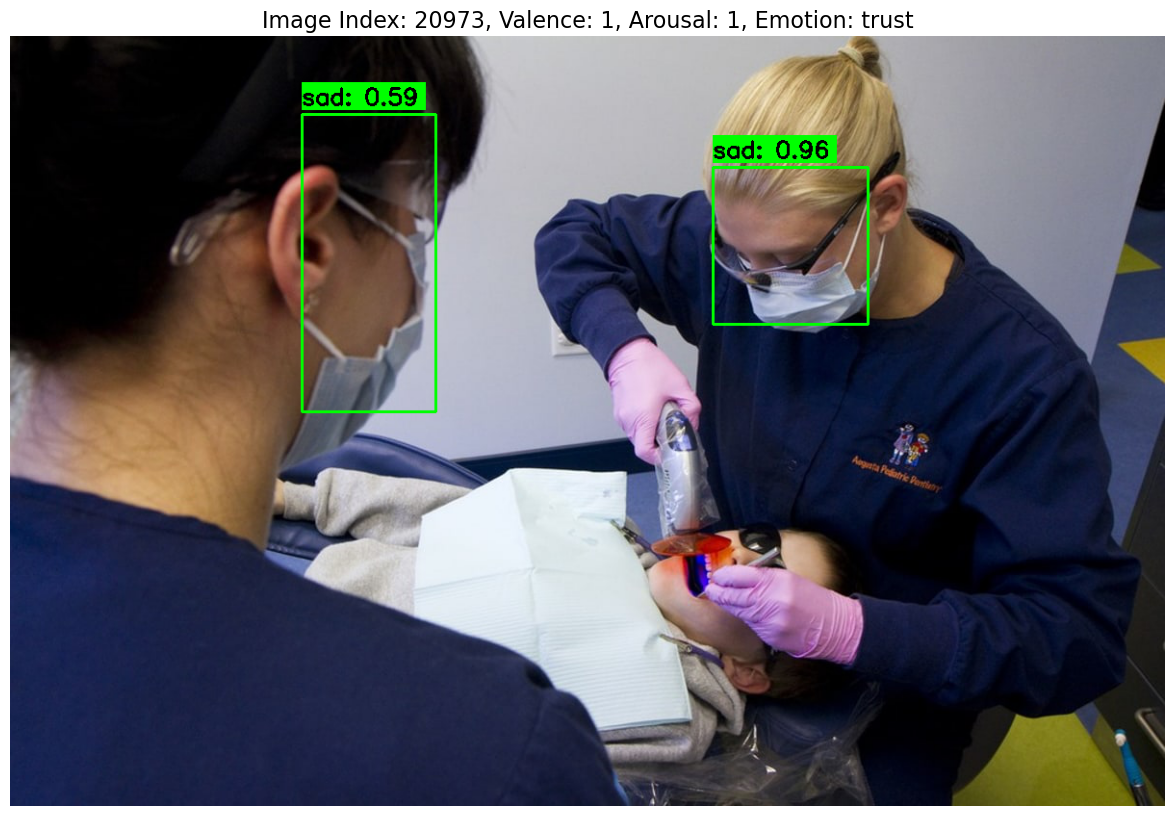

Base model (365 categories):
  veterinarians_office: 0.2291
  art_school: 0.1508
  hospital_room: 0.0988


Testing: test_va
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.83,2.95): 0.1998
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,4.13,2.62): 0.1315
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.59,2.89): 0.0862
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.65,2.99): 0.0794
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.84,2.58): 0.0676
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.59,2.6): 0.0473
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.89,2.73): 0.0397
  test_va(tensor(face_predictions(20973)),tensor(scene_predictions(20973)),0.9,1.5,3.87,2.56): 0.0362
  test_va(tensor(face_predictions(20973)),tensor(scene_predic

In [419]:
test_idx = random.choice(test_indices)
show_pretrained_model_predictions_on_sample(test_idx)

debug_query(model,
            "test_va",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Var("FV"),
            Var("FA"),
            Var("SV"),
            Var("SA"))

debug_query(model,
            "test_combo",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Var("CA"),
            Var("CV"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Term("tensor", Term("face_features", Constant(test_idx))),
            Term("tensor", Term("scene_features", Constant(test_idx))),
            Var("Emotion"))

print("Debugging queries done.")

In [420]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter,
    test_iter = 20 * log_iter,
    test=lambda x :[
        ("test_accuracy", evaluate_dpl_with_metrics(model, test_dataset)['accuracy'])
    ],
    initial_test = False
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:35.1963 	Average Loss:  1.1257518902420998
0.43100734477063274	0.5689926552293674	0.4233816567741512	0.5766183432258488	0.24582840276059056	0.7541715972394094	0.38910571517896825	0.6108942848210317
Iteration:  4 	s:72.7136 	Average Loss:  2.3221379965543747
0.4437111329884532	0.5562888670115469	0.43697583916129806	0.5630241608387019	0.2682561449999721	0.7317438550000278	0.390303340040873	0.6096966599591269
Iteration:  6 	s:67.6001 	Average Loss:  2.1748871030285954
0.45484409200900455	0.5451559079909956	0.45016036834910855	0.5498396316508914	0.286979052418642	0.7130209475813579	0.3917694441826532	0.6082305558173468
Iteration:  8 	s:61.6324 	Average Loss:  2.1849865512922406
0.46529173174433397	0.5347082682556661	0.46205420008380416	0.5379457999161958	0.3068064128320125	0.6931935871679875	0.39250293180577106	0.6074970681942289
Iteration:  10 	s:64.1527 	Average Loss:  1.882900780532509
0.47115456216603935	0.5288454378339607	0.46946211119

KeyboardInterrupt: 